# Total Correation with Iterative Gaussianization

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    import os
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")
    
finally:
    # import library functions
    from rbig_jax.data import get_classic
    from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
    from rbig_jax.models.itergauss import IterativeGaussianization
    from rbig_jax.information.total_corr import total_correlation

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Total Correlation

#### Toy Data

In [2]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 30

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

# closed Form
tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 35.2632



### RBIG Estimator

In [6]:
from rbig_jax.information.total_corr import total_correlation
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.histogram import InitUniHistUniformize


In [7]:
X = np.array(data, dtype=np.float32)

# initialize histogram transformation
n_samples = X.shape[0]
nbins = int(np.sqrt(n_samples))
support_extension = 10
precision = 1_000
alpha = 1e-5

uni_uniformize = InitUniHistUniformize(
            n_samples=n_samples,
            nbins=nbins,
            support_extension=support_extension,
            precision=precision,
            alpha=alpha,
        )

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize total correlation transformation
eps = 1e-5
zero_tolerance = 30
max_layers = 1_000
p = 0.25
return_all = True


### Info Loss While Loop

In [8]:
%%time

X = np.array(data, dtype=np.float32)

X_g, info_loss = total_correlation(
    X=X.block_until_ready(),
    uni_uniformize=uni_uniformize,
    rot_transform=rot_transform,
    eps=eps,
    zero_tolerance=zero_tolerance,
    max_layers=max_layers,
    p=p,
    return_all=return_all
)

CPU times: user 21.2 s, sys: 11 s, total: 32.1 s
Wall time: 16 s


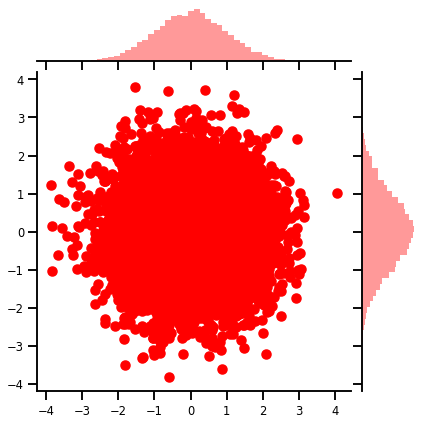

In [9]:
sns.jointplot(X_g[:, 0], X_g[:, 1], color="red")

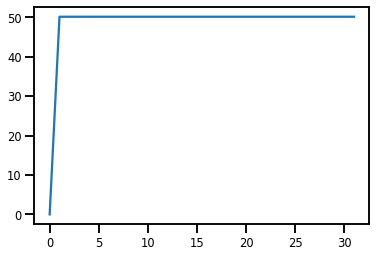

In [10]:
plt.plot(np.cumsum(info_loss))

In [11]:
np.sum(info_loss) * np.log(2)

DeviceArray(34.73287282, dtype=float64)


### Without Extras

In [12]:
%%time

tc = total_correlation(
    X=X.block_until_ready(),
    uni_uniformize=uni_uniformize,
    rot_transform=rot_transform,
    eps=eps,
    zero_tolerance=zero_tolerance,
    max_layers=max_layers,
    p=p,
    return_all=False,
    base=2
)

print(tc)

34.7328728180383


### Max Layers Iteration

In [6]:
from rbig_jax.information.total_corr import total_correlation_max_layers

In [7]:
%%time
X = np.array(data, dtype=np.float32)

X_g, info_loss = total_correlation_max_layers(
    X=X.block_until_ready(),
    uni_uniformize=uni_uniformize,
    rot_transform=rot_transform,
    eps=eps,
    max_layers=max_layers,
    p=p,
    return_all=return_all
)

CPU times: user 7.5 s, sys: 61.7 ms, total: 7.56 s
Wall time: 7.55 s


In [9]:
%%time

tc = total_correlation_max_layers(
    X=X.block_until_ready(),
    uni_uniformize=uni_uniformize,
    rot_transform=rot_transform,
    eps=eps,
    max_layers=max_layers,
    p=p,
    return_all=False
)
print(tc * np.log(2))

In [ ]:
sns.jointplot(X_g[:, 0], X_g[:, 1], color="red")

In [ ]:
plt.plot(np.cumsum(info_loss))

In [4]:
from rbig_jax.information.entropy import histogram_entropy
from rbig_jax.transforms.histogram import histogram_transform
from rbig_jax.information.total_corr import rbig_total_correlation

#### Marginal Uniformization

In [5]:
from rbig_jax.transforms.histogram import get_hist_params

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(data.shape[0]))
return_params = False

uniformize_transform = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
    return_params=return_params
)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


#### Univariate Entropy

In [6]:
# define marginal entropy function
entropy_f = jax.partial(histogram_entropy, nbins=1_000, base=2)

## TC w. Scan Function

In [7]:
%%time
n_iterations = 20
p = 0.1

X_trans, loss = rbig_total_correlation(
    np.array(data), 
    marginal_uni=uniformize_transform, 
    uni_entropy=entropy_f, 
    n_iterations=n_iterations,
    p=p
)

CPU times: user 5.17 s, sys: 45.2 ms, total: 5.21 s
Wall time: 5.2 s


In [8]:
%%time
total_corr = np.sum(loss) * np.log(2)

CPU times: user 130 ms, sys: 18.7 ms, total: 149 ms
Wall time: 20.3 ms


In [9]:
%%time

print(f"Estimated TC: {total_corr:.4f}")

Estimated TC: 34.8091
CPU times: user 31.7 s, sys: 1min 40s, total: 2min 11s
Wall time: 2.51 s


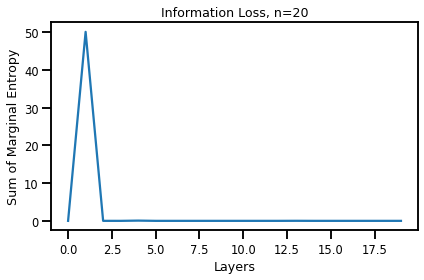

In [10]:
plot_info_loss(loss, n_layers=len(loss))

## While Loop

In [ ]:
init_state = MaxLoss(layer=0, max_layers=n_layers), X_g, params

def body(state):
    loss_state, x = state

    x, _ = fit_transform_func_jitted(x)
    
    params.append(layer_params)  
    state = MaxLoss(layer=loss_state.layer + 1, max_layers=loss_state.max_layers), x
    
    return state
    
final_state = jax.lax.while_loop(max_condition, body, init_state)